In [1]:
from pybedtools import BedTool
import matplotlib.pyplot as plt
import numpy as np
import os

## CTCF Recall and Precision

In [2]:
def num_regions(bedfile):
    return len(bedfile)

def recall_precision(ctcf_bed, peak_bedgraph):
    """
    Calculates recall and precision for CTCF binding sites.

    Args:
        ctcf_bed (str): Path to CTCF motif BED file.
        peak_bedgraph (str): Path to peak bedgraph file.

    Returns:
        tuple: (recall, precision, total_peak_regions, peaks_with_ctcf)
    """
    print(f"peak_bedgraph: {peak_bedgraph}")
    ctcf_regions = BedTool(ctcf_bed)
    peak_regions = BedTool(peak_bedgraph)
    print(f"Num peak regions: {num_regions(peak_regions)}")

    num_ctcf = num_regions(ctcf_regions)
    print(f"Number of CTCF regions: {num_ctcf}")

    # Overlap CTCF regions with peaks
    overlapping_from_ctcf_regions = ctcf_regions.intersect(peak_regions, u=True)
    num_overlapping_ctcf = num_regions(overlapping_from_ctcf_regions)
    print(f"Number of CTCF overlapping regions: {num_overlapping_ctcf}")

    recall = num_overlapping_ctcf / num_ctcf if num_ctcf > 0 else 0

    # Overlap peaks with CTCF regions
    peaks_with_ctcf = peak_regions.intersect(ctcf_regions, u=True)
    num_peaks_with_ctcf = num_regions(peaks_with_ctcf)
    print(f"Number of peaks with CTCF: {num_peaks_with_ctcf}")

    precision = num_peaks_with_ctcf / num_regions(peak_regions) if num_regions(peak_regions) > 0 else 0

    return recall, precision, num_regions(peak_regions), num_peaks_with_ctcf

In [3]:
def plot_recall_precision(
    ctcf_bed,
    before_bed,
    after_bed,
    outfile='ctcf_recall_precision_plot.png',
    cell_line='GM12878',
    sample='ENCFF355CYX',
    fdr='0.1',
    bar_labels=['Before', 'After'],
    experiment_type='ChIP-Seq'
):
    """
    Plots recall and precision for CTCF binding sites before and after chrom-sig.

    Args:
        ctcf_bed (str): Path to CTCF motif BED file.
        before_bed (str): Path to peak bedgraph file before chrom-sig.
        after_bed (str): Path to peak bedgraph file after chrom-sig.
        outfile (str): Output filename for the plot.
        cell_line (str): Cell line name.
        sample (str): Sample name.
        fdr (str): FDR value.
    """

    before_recall, before_precision, before_total_regions, before_ctcf_regions = recall_precision(ctcf_bed, before_bed)
    after_recall, after_precision, after_total_regions, after_ctcf_regions = recall_precision(ctcf_bed, after_bed)

    height = 0.35  # Bar height
    labels = ['Recall', 'Precision']
    x = np.arange(len(labels))  # [0, 1]

    before_scores = [before_recall, before_precision]
    after_scores = [after_recall, after_precision]

    plt.figure(figsize=(8, 6))
    bars1 = plt.barh(x + height/2, before_scores, height, label=bar_labels[0], color='skyblue')
    bars2 = plt.barh(x - height/2, after_scores, height, label=bar_labels[1], color='orange')
    plt.xlim(0, 1)
    plt.yticks(x, labels)
    plt.xlabel('Score')
    plt.title(f'Recall and Precision of CTCF Motifs {cell_line} {experiment_type} {sample} FDR {fdr}')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()

    # Add score labels and region counts to each bar
    for i, bar in enumerate(bars1):
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.3f}",
                 va='center', ha='left', fontsize=10)
        if i == 1:
            plt.text(0.01, bar.get_y() + bar.get_height()/2 - 0.08,
                     f"Total regions: {before_total_regions}", va='center', ha='left', fontsize=10)
            plt.text(0.01, bar.get_y() + bar.get_height()/2 + 0.08,
                     f"CTCF regions: {before_ctcf_regions}", va='center', ha='left', fontsize=10)
    for i, bar in enumerate(bars2):
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.3f}",
                 va='center', ha='left', fontsize=10)
        if i == 1:
            plt.text(0.01, bar.get_y() + bar.get_height()/2 - 0.08,
                     f"Total regions: {after_total_regions}", va='center', ha='left', fontsize=10)
            plt.text(0.01, bar.get_y() + bar.get_height()/2 + 0.08,
                     f"CTCF regions: {after_ctcf_regions}", va='center', ha='left', fontsize=10)

    #plt.savefig(outfile)
    plt.close()


In [4]:
ctcf_bed = '/nfs/turbo/umms-minjilab/zapell/chrom-sig/data/CTCF_motifs_STORM_hg38_Ext4kbBoth.sorted.id.bed'

### GM12878 4DNFI9U71IB4 CTCF CUTRUN at different FDR

In [6]:
# GM12878 CUT&RUN example
before_bed = '/nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_CUTRUN_CTCF_4DNFI9U71IB4_raw_SICER.bedgraph'
after_bed_fdr1 = '/nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_CUTRUN_CTCF_4DNFI9U71IB4_chrom-sig_FDR0.1_pseudoRead_5000_SICER.bedgraph'
after_bed_fdr2 = '/nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_CUTRUN_CTCF_4DNFI9U71IB4_chrom-sig_FDR0.2_pseudoRead_5000_SICER.bedgraph'

plot_recall_precision(
        ctcf_bed, before_bed, after_bed_fdr1,
        outfile='plots/GM12878_CUTRUN_CTCF_4DNFI9U71IB4_precision_recall_plot_FDR0.1.png',
        cell_line='GM12878', sample='4DNFI9U71IB4', fdr='0.1'
    )
plot_recall_precision(
        ctcf_bed, before_bed, after_bed_fdr2,
        outfile='plots/GM12878_CUTRUN_CTCF_4DNFI9U71IB4_precision_recall_plot_FDR0.2.png',
        cell_line='GM12878', sample='4DNFI9U71IB4', fdr='0.2'
    )
 

peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_CUTRUN_CTCF_4DNFI9U71IB4_raw_SICER.bedgraph
Num peak regions: 62176
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 21323
Number of peaks with CTCF: 23799
peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_CUTRUN_CTCF_4DNFI9U71IB4_chrom-sig_FDR0.1_pseudoRead_5000_SICER.bedgraph
Num peak regions: 19233
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 14437
Number of peaks with CTCF: 14198
peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_CUTRUN_CTCF_4DNFI9U71IB4_raw_SICER.bedgraph
Num peak regions: 62176
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 21323
Number of peaks with CTCF: 23799
peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_CUTRUN_CTCF_4DNFI9U71IB4_chrom-sig_FDR0.2_pseudoRead_5000_SICER.bedgraph
Num peak regions: 31957
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 18363
Num

### Recall and precision at varying SICER e-vals and top N peaks

We compare recall and precision for peaks called using SICER at different e-vals compared to Chrom-Sig at FDR 0.1 and 5000 pseudoreads.  
We compare recall and precision for the top N peaks called using SICER compared to Chrom-Sig at FDR 0.1 and 5000 pseudoreads.  

#### GM12878 ENCFF355CYX CTCF ChIP-seq



In [7]:

# CTCF ChIP-Seq example

# run motif on GM12878 CUT&RUN without chrom-sig at different SICER e-vals and compare to chrom-sig results
SICER_DIR = '/nfs/turbo/umms-minjilab/njgupta/chromsig/SICER_BASIC/'
e_vals = ['GM12878_CTCF_ChIP-seq_ENCFF355CYX_bam2bed.std-W200-G600_e1500.scoreisland',
    'GM12878_CTCF_ChIP-seq_ENCFF355CYX_bam2bed.std-W200-G600_e2000.scoreisland',
    'GM12878_CTCF_ChIP-seq_ENCFF355CYX_bam2bed.std-W200-G600_e500.scoreisland',
    'GM12878_CTCF_ChIP-seq_ENCFF355CYX_bam2bed.std-W200-G600_e750.scoreisland']

top_peaks = ['GM12878_CTCF_ChIP-seq_ENCFF355CYX_bam2bed.std-W200-G600.scoreisland_top_10000_peaks.bed',
    'GM12878_CTCF_ChIP-seq_ENCFF355CYX_bam2bed.std-W200-G600.scoreisland_top_1000_peaks.bed',
    'GM12878_CTCF_ChIP-seq_ENCFF355CYX_bam2bed.std-W200-G600.scoreisland_top_15000_peaks.bed',
    'GM12878_CTCF_ChIP-seq_ENCFF355CYX_bam2bed.std-W200-G600.scoreisland_top_20000_peaks.bed',
    'GM12878_CTCF_ChIP-seq_ENCFF355CYX_bam2bed.std-W200-G600.scoreisland_top_5000_peaks.bed']

chrom_sig_bed = '/nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_ChIP-seq_CTCF_ENCFF355CYX_chrom-sig_FDR0.1_pseudoRead5000_SICER.bed'
    # make outdir if it doesnt exist
outdir = '/nfs/turbo/umms-minjilab/zapell/chrom-sig/plots/revisions/CTCF_CHIP-Seq_ENCFF355CYX'
os.makedirs(outdir, exist_ok=True)
for file in e_vals:
    e_val_bed = SICER_DIR + file
    e_val = file.split('_e')[-1].split('.')[0]
    plot_recall_precision(
            ctcf_bed, e_val_bed, chrom_sig_bed,
            outfile=f'{outdir}/e_val{e_val}_vs_Chrom-Sig_precision_recall_plot.png',
            cell_line='GM12878', sample='ENCFF355CYX', fdr=0.1,
            bar_labels=[f'e-val {e_val}', 'Chrom-Sig']
    )
    
for file in top_peaks:
    top_peak_bed = SICER_DIR + file
    num_peaks = file.split('_top_')[-1].split('_peaks')[0]
    plot_recall_precision(
            ctcf_bed, top_peak_bed, chrom_sig_bed,
            outfile=f'{outdir}/top_{num_peaks}_peaks_vs_Chrom-Sig_precision_recall_plot.png',
            cell_line='GM12878', sample='ENCFF355CYX', fdr=0.1,
            bar_labels=[f'Top {num_peaks} peaks', 'Chrom-Sig']
    )


   

peak_bedgraph: /nfs/turbo/umms-minjilab/njgupta/chromsig/SICER_BASIC/GM12878_CTCF_ChIP-seq_ENCFF355CYX_bam2bed.std-W200-G600_e1500.scoreisland
Num peak regions: 37271
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 22090
Number of peaks with CTCF: 22674
peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_ChIP-seq_CTCF_ENCFF355CYX_chrom-sig_FDR0.1_pseudoRead5000_SICER.bed
Num peak regions: 24872
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 19074
Number of peaks with CTCF: 19132
peak_bedgraph: /nfs/turbo/umms-minjilab/njgupta/chromsig/SICER_BASIC/GM12878_CTCF_ChIP-seq_ENCFF355CYX_bam2bed.std-W200-G600_e2000.scoreisland
Num peak regions: 37804
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 22145
Number of peaks with CTCF: 22780
peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_ChIP-seq_CTCF_ENCFF355CYX_chrom-sig_FDR0.1_pseudoRead5000_SICER.bed
Num peak regions: 24872
Number of CTCF regions: 226

#### GM12878 4DNFI2G71DR4 CTCF CUTRUN

In [5]:
 # run motif on GM12878 CUT&RUN without chrom-sig at different SICER e-vals and compare to chrom-sig results
CR_SICER = '/nfs/turbo/umms-minjilab/njgupta/chromsig/SICER_CUTandRUN'

CR_e_vals = ['GM12878_CUTandRUN_CTCF_4DNFI2G71DR4_bam2bed.std-W200-G600_e1500.scoreisland',
    'GM12878_CUTandRUN_CTCF_4DNFI2G71DR4_bam2bed.std-W200-G600_e2000.scoreisland',
    'GM12878_CUTandRUN_CTCF_4DNFI2G71DR4_bam2bed.std-W200-G600_e500.scoreisland',
    'GM12878_CUTandRUN_CTCF_4DNFI2G71DR4_bam2bed.std-W200-G600_e750.scoreisland']

CR_top_peaks = ['GM12878_CUTandRUN_CTCF_4DNFI2G71DR4_bam2bed.std-W200-G600.scoreisland_top_10000_peaks.bed',
    'GM12878_CUTandRUN_CTCF_4DNFI2G71DR4_bam2bed.std-W200-G600.scoreisland_top_1000_peaks.bed',
    'GM12878_CUTandRUN_CTCF_4DNFI2G71DR4_bam2bed.std-W200-G600.scoreisland_top_15000_peaks.bed',
    'GM12878_CUTandRUN_CTCF_4DNFI2G71DR4_bam2bed.std-W200-G600.scoreisland_top_20000_peaks.bed',
    'GM12878_CUTandRUN_CTCF_4DNFI2G71DR4_bam2bed.std-W200-G600.scoreisland_top_5000_peaks.bed']

cr_outdir = '/nfs/turbo/umms-minjilab/zapell/chrom-sig/plots/revisions/CTCF_CUTRUN_4DNFI2G71DR4'
os.makedirs(cr_outdir, exist_ok=True)
chrom_sig_cr_bed = '/nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_CUTRUN_CTCF_4DNFI2G71DR4_chrom-sig_FDR0.1_pseudoRead_5000_SICER.bed'
for file in CR_e_vals:
    e_val_bed = CR_SICER + '/' + file
    e_val = file.split('_e')[-1].split('.')[0]
    plot_recall_precision(
            ctcf_bed, e_val_bed, chrom_sig_cr_bed,
            outfile=f'{cr_outdir}/GM12878_CR_4DNFI2G71DR4_e_val{e_val}_vs_Chrom-Sig_precision_recall_plot.png',
            cell_line='GM12878', sample='4DNFI2G71DR4', fdr=0.1,
            bar_labels=[f'e-val {e_val}', 'Chrom-Sig'],
            experiment_type='CUT&RUN'
        )

for file in CR_top_peaks:
    top_peak_bed = CR_SICER + '/' + file
    num_peaks = file.split('_top_')[-1].split('_peaks')[0]
    plot_recall_precision(
            ctcf_bed, top_peak_bed, chrom_sig_cr_bed,
            cell_line='GM12878', sample='4DNFI2G71DR4', fdr=0.1,
            outfile=f'{cr_outdir}/GM12878_CR_4DNFI2G71DR4_top_{num_peaks}_peaks_vs_Chrom-Sig_precision_recall_plot.png',
            bar_labels=[f'Top {num_peaks} peaks', 'Chrom-Sig'],
            experiment_type='CUT&RUN'
    )


 

peak_bedgraph: /nfs/turbo/umms-minjilab/njgupta/chromsig/SICER_CUTandRUN/GM12878_CUTandRUN_CTCF_4DNFI2G71DR4_bam2bed.std-W200-G600_e1500.scoreisland
Num peak regions: 56726
Num peak regions: 56726
Number of CTCF regions: 22648
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 20950
Number of CTCF overlapping regions: 20950
Number of peaks with CTCF: 22772
Number of peaks with CTCF: 22772
peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_CUTRUN_CTCF_4DNFI2G71DR4_chrom-sig_FDR0.1_pseudoRead_5000_SICER.bed
Num peak regions: 16774
peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/GM12878_CUTRUN_CTCF_4DNFI2G71DR4_chrom-sig_FDR0.1_pseudoRead_5000_SICER.bed
Num peak regions: 16774
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 12831
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 12831
Number of peaks with CTCF: 12547
Number of peaks with CTCF: 12547
peak_bedgraph: /nfs/turbo/umms-minjilab/njgupta/chromsig/SI

## AtacWorks Comparison

We are comparing AtacWorks to Chrom-Sig for 2 CTCF ChIP-Seq replicate pairs and CTCF CUTRUN replicates.  
AtacWorks was trained using the [pretrained bulk lowqual 20M reads model](https://api.ngc.nvidia.com/v2/models/org/nvidia/atac_bulk_lowqual_20m_20m/0.3/files?redirect=true&path=models/model.pth.tar) with the default parameters.

### Precision and Recall Comparison

In [6]:
# atac works recall comparison
AW_dir = '/nfs/turbo/umms-minjilab/zapell/chrom-sig/data/AtacWorks_sorted'
CS_dir = '/nfs/turbo/umms-minjilab/zapell/chrom-sig/data/CS_sorted'
aw_outdir = '/nfs/turbo/umms-minjilab/zapell/chrom-sig/plots/revisions/CTCF_AtacWorks_vs_Chrom-Sig'
os.makedirs(aw_outdir, exist_ok=True)
atac_works_beds = [
        AW_dir + '/AW_GM12878_CTCF_ChIP1_ENCFF355CYX_sorted.bed',
        AW_dir + '/AW_GM12878_CTCF_ChIP1_ENCFF453EJM_sorted.bed',
        AW_dir + '/AW_GM12878_CTCF_ChIP2_ENCFF500UFQ_sorted.bed',
        AW_dir + '/AW_GM12878_CTCF_ChIP2_ENCFF668ROZ_sorted.bed',
        AW_dir + '/AW_GM12878_CTCF_CUTRUN1_DR4_sorted.bed',
        AW_dir + '/AW_GM12878_CTCF_CUTRUN2_IB4_sorted.bed'
]

cs_beds = [
        CS_dir + '/GM12878_CTCF_ChIP1_ENCFF355CYX_sorted.bed',
        CS_dir + '/GM12878_CTCF_ChIP1_ENCFF453EJM_sorted.bed',
        CS_dir + '/GM12878_CTCF_ChIP2_ENCFF500UFQ_sorted.bed',
        CS_dir + '/GM12878_CTCF_ChIP2_ENCFF668ROZ_sorted.bed',
        CS_dir + '/GM12878_CTCF_CUTRUN1_DR4_sorted.bed',
        CS_dir + '/GM12878_CTCF_CUTRUN1_IB4_sorted.bed'
]

samples = [
        'ENCFF355CYX_ChIP1',
        'ENCFF453EJM_ChIP1',
        'ENCFF500UFQ_ChIP2',
        'ENCFF668ROZ_ChIP2',
        '4DNFI2G71DR4_CUTRUN1',
        '4DNFI9U71IB4_CUTRUN1'
]

for i in range(len(atac_works_beds)):
    aw_bed = atac_works_beds[i]
    cs_bed = cs_beds[i]
    sample = samples[i]
    plot_recall_precision(
        ctcf_bed, aw_bed, cs_bed,
        outfile=f'{aw_outdir}/GM12878_CTCF_{sample}_AtacWorks_vs_Chrom-Sig_precision_recall_plot.png',
        cell_line='GM12878', sample=sample, fdr='0.1',
        bar_labels=['AtacWorks', 'Chrom-Sig'],
        experiment_type='AtacWorks vs Chrom-Sig'
        )

peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/AtacWorks_sorted/AW_GM12878_CTCF_ChIP1_ENCFF355CYX_sorted.bed
Num peak regions: 445
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 140
Number of peaks with CTCF: 153
peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/CS_sorted/GM12878_CTCF_ChIP1_ENCFF355CYX_sorted.bed
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 140
Number of peaks with CTCF: 153
peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/CS_sorted/GM12878_CTCF_ChIP1_ENCFF355CYX_sorted.bed
Num peak regions: 24872
Num peak regions: 24872
Number of CTCF regions: 22648
Number of CTCF regions: 22648
Number of CTCF overlapping regions: 19074
Number of CTCF overlapping regions: 19074
Number of peaks with CTCF: 19132
Number of peaks with CTCF: 19132
peak_bedgraph: /nfs/turbo/umms-minjilab/zapell/chrom-sig/data/AtacWorks_sorted/AW_GM12878_CTCF_ChIP1_ENCFF453EJM_sorted.bed
Num peak regions: 1635
peak_bedgraph: /nfs

In [7]:
# function to plot distribution of peak sizes between Chrom-Sig and AtacWorks
def plot_peak_size_distribution(chrom_sig_bed, atac_works_bed, 
                                outfile='peak_size_distribution.png', 
                                cell_line='GM12878', 
                                sample='ENCFF355CYX', 
                                fdr='0.1'):
    chrom_sig_regions = BedTool(chrom_sig_bed)
    atac_works_regions = BedTool(atac_works_bed)
    chrom_sig_sizes = [min(region.length, 5000) for region in chrom_sig_regions]
    atac_works_sizes = [min(region.length, 5000) for region in atac_works_regions]

    num_chrom_sig_peaks = len(chrom_sig_sizes)
    num_atac_works_peaks = len(atac_works_sizes)

    plt.figure(figsize=(10, 6))
    plt.hist(chrom_sig_sizes, bins=50, alpha=0.5, label=f'Chrom-Sig (n={num_chrom_sig_peaks})', color='blue', density=True)
    plt.hist(atac_works_sizes, bins=50, alpha=0.5, label=f'AtacWorks (n={num_atac_works_peaks})', color='orange', density=True)
    plt.xlabel('Peak Size (bp)')
    plt.ylabel('Density')
    plt.title(f'Peak Size Distribution {cell_line} {sample} FDR {fdr}')

    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.savefig(outfile)
    plt.close() 


### Peak Size Distribution Comparison

Note: SICER calls peaks in 200bp interval sizes, hence the discretized distribution.  
Peaks larger than 5000bp were binned into 5000bp bin for visualization.  

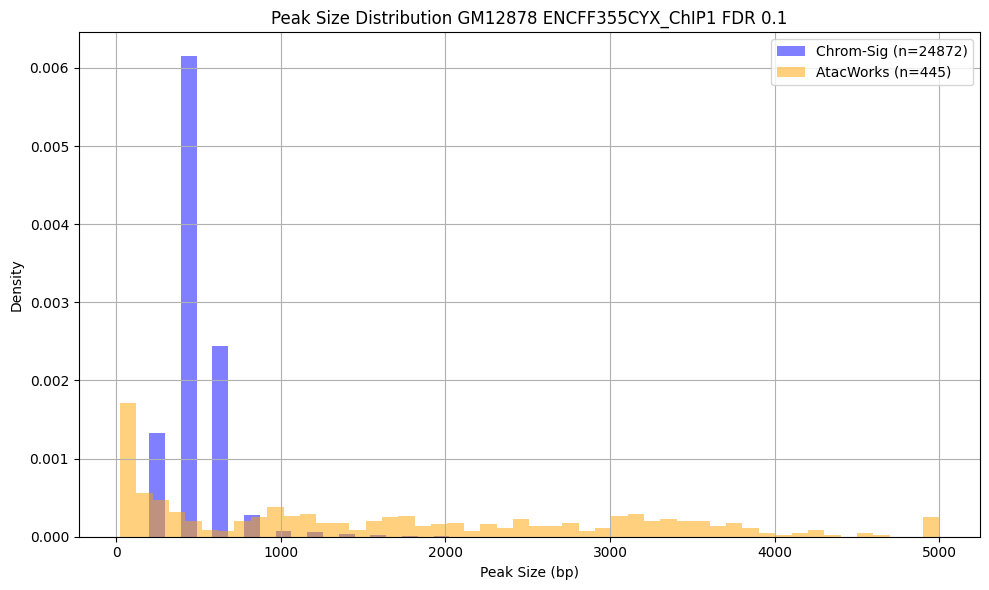

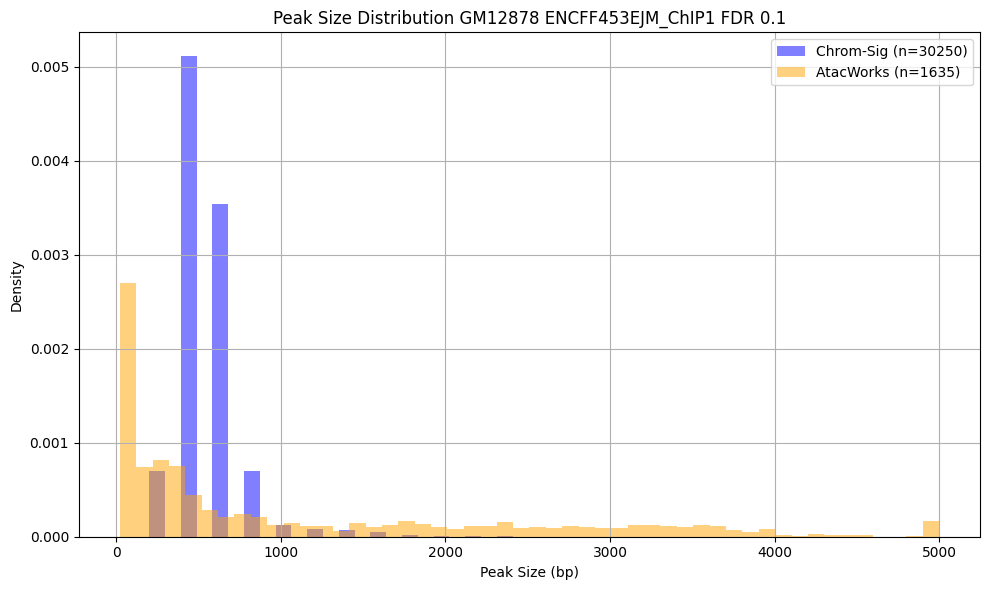

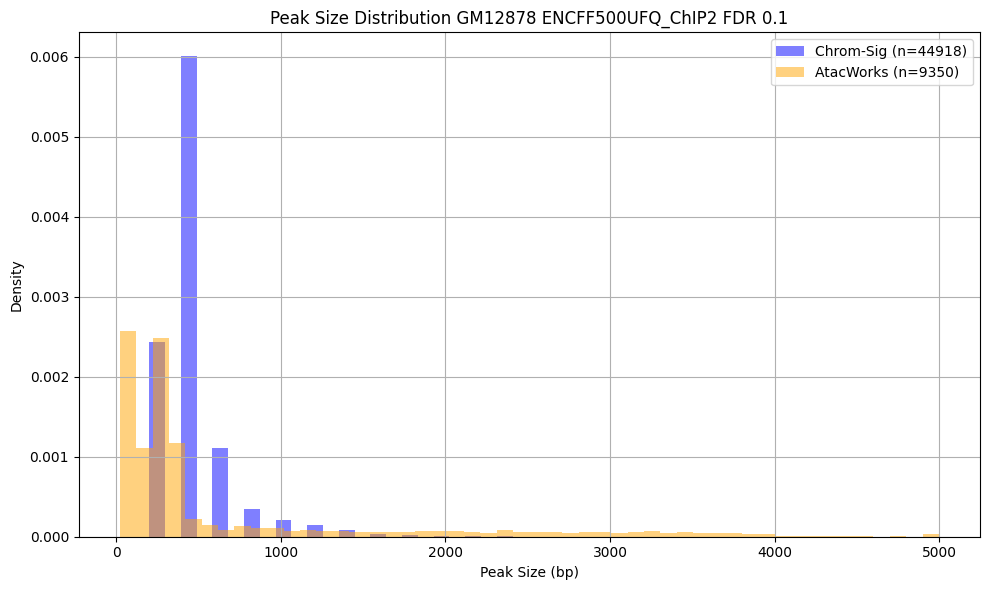

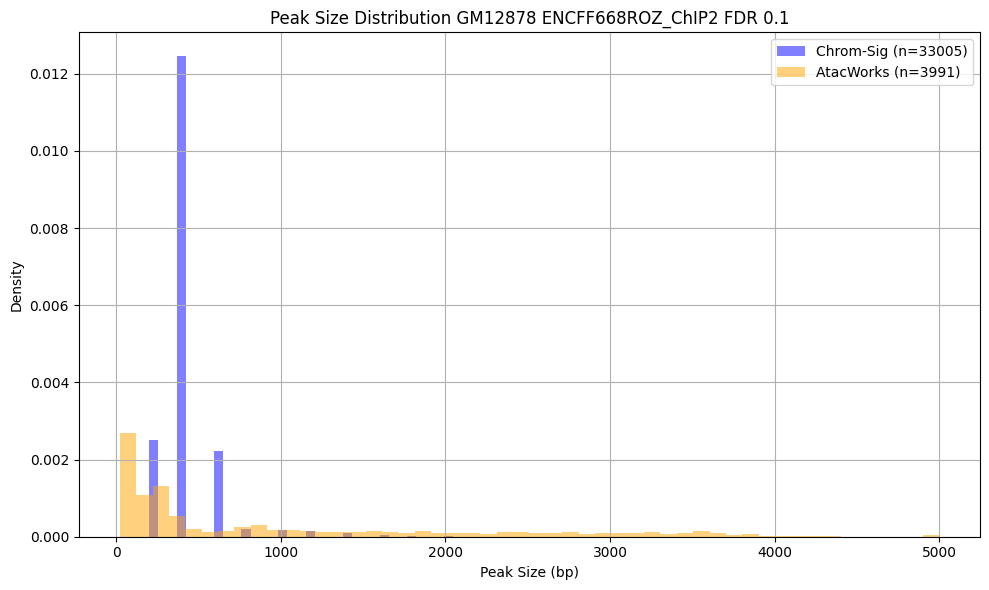

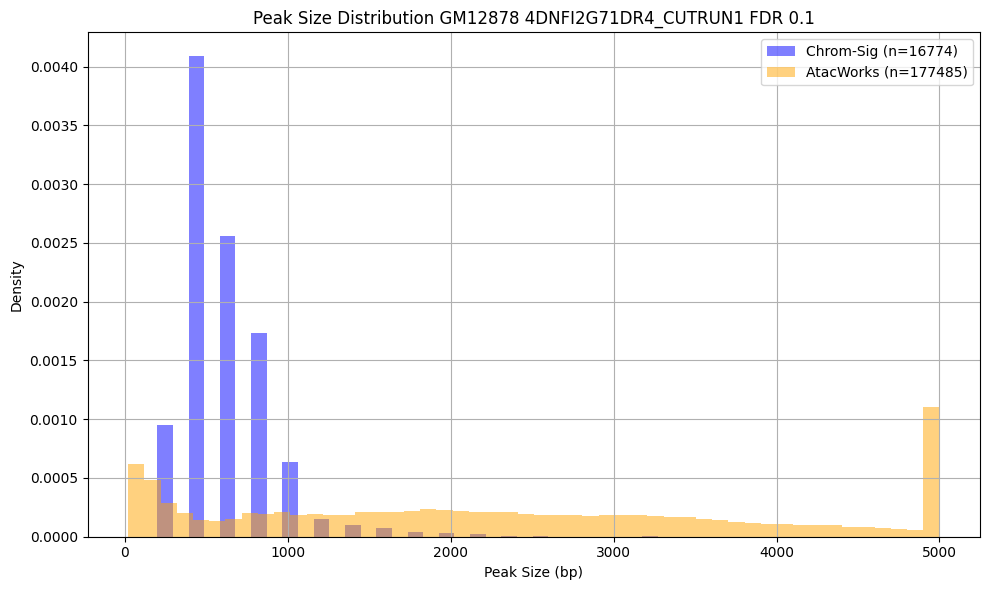

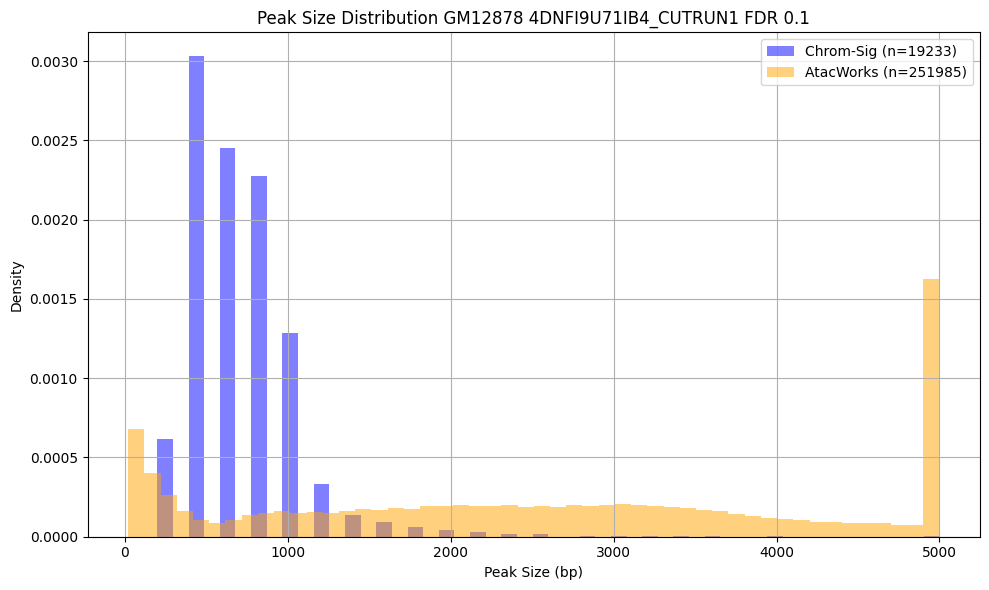

In [8]:
for i in range(len(atac_works_beds)):
    aw_bed = atac_works_beds[i]
    cs_bed = cs_beds[i]
    sample = samples[i]
    plot_peak_size_distribution(
        chrom_sig_bed=cs_bed,
        atac_works_bed=aw_bed,
        outfile=f'{aw_outdir}/GM12878_CTCF_{sample}_peak_size_distribution.png',
        cell_line='GM12878', sample=sample)


### ATAC-Seq peak distribution comparison

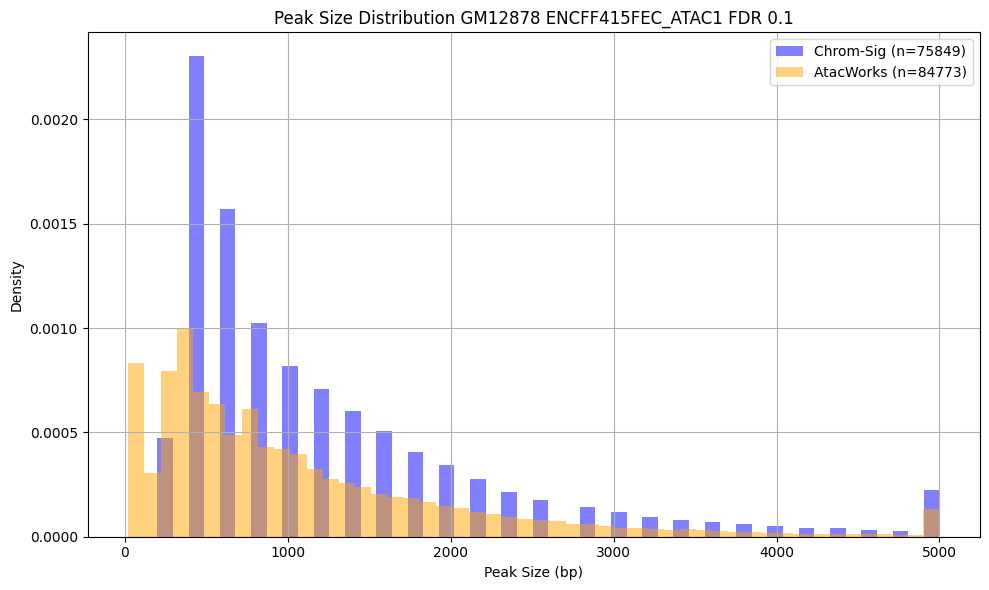

In [9]:
plot_peak_size_distribution(
    chrom_sig_bed=CS_dir + '/GM12878_ATAC1_ENCFF415FEC_sorted.bed',
    atac_works_bed=AW_dir + '/AW_GM12878_ATAC1_ENCFF415FEC_sorted.bed',
    outfile=f'{aw_outdir}/GM12878_ATAC1_ENCFF415FEC_peak_size_distribution.png',
    cell_line='GM12878', sample='ENCFF415FEC_ATAC1')

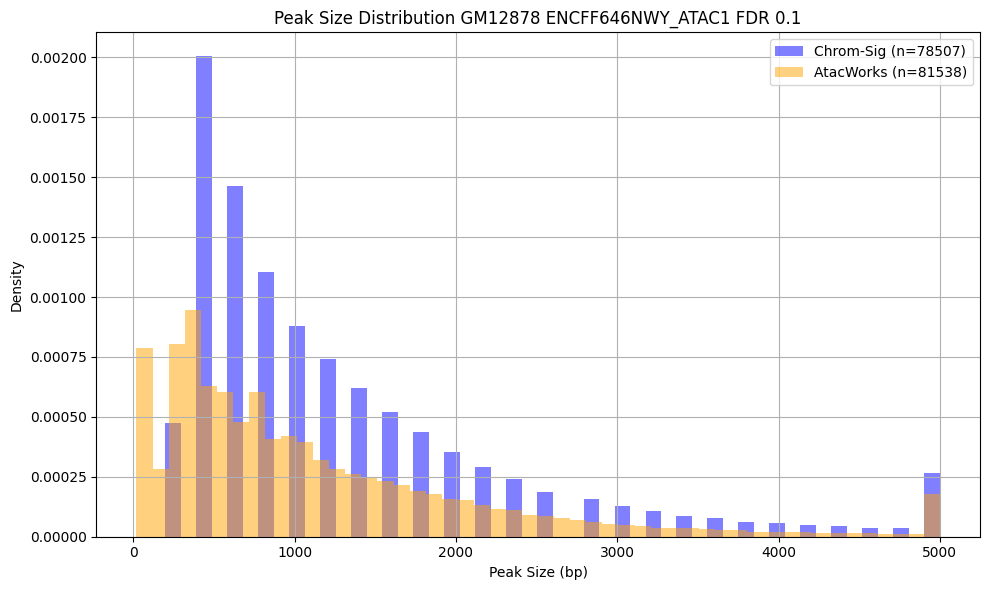

In [10]:
plot_peak_size_distribution(
    chrom_sig_bed=CS_dir + '/GM12878_ATAC1_ENCFF646NWY_sorted.bed',
    atac_works_bed=AW_dir + '/AW_GM12878_ATAC1_ENCFF646NWY_sorted.bed',
    outfile=f'{aw_outdir}/GM12878_ATAC1_ENCFF646NWY_peak_size_distribution.png',
    cell_line='GM12878', sample='ENCFF646NWY_ATAC1')